In [18]:
import numpy as np
import pandas as pd
import operator
import random
import math
from copy import deepcopy
from functools import partial
from deap import gp, base, creator, tools, algorithms
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
PATH_TRAIN = "./data/train.csv"
PATH_TEST = "./data/test.csv"

DTYPES_FEATURES = {
    "id": "uint64",
    "fr_COO": "category",
    "fr_COO2": "category",
}

DTYPES_TARGETS = {
    "EC1": "bool",
    "EC2": "bool",
    "EC3": "bool",
    "EC4": "bool",
    "EC5": "bool",
    "EC6": "bool",
}

DROP_COLS = ["EC3", "EC4", "EC5", "EC6"]


def _load_data(datapath: str, dtypes: dict, drop_cols: list) -> pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=datapath, dtype=dtypes, index_col="id").drop(
        columns=drop_cols, axis=1
    )


GetTrainDF = partial(
    _load_data,
    datapath=PATH_TRAIN,
    dtypes=dict(**DTYPES_TARGETS, **DTYPES_FEATURES),
    drop_cols=DROP_COLS,
)
GetTestDF = partial(
    _load_data, datapath=PATH_TEST, dtypes=DTYPES_FEATURES, drop_cols=[]
)

df_test = GetTestDF().astype(float)
df_train = GetTrainDF().astype(float)
df_train.head()

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
id,,,,,,,,,,,,,,,,,,,,,
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0.0,0.0,1.0,1.0
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0.0,0.0,0.0,1.0
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0.0,0.0,1.0,1.0
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0.0,0.0,1.0,1.0
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,632.207041,10.911303,6.579933,9.179964,4.653583,6.030052,3.670528,1.770579,32.971529,6.606882,...,13.847474,6.923737,34.407699,32.607024,18.947452,61.376610,0.0,0.0,1.0,1.0
14834,62.568425,2.642734,1.446898,1.446898,0.879497,0.879497,0.174620,0.000000,0.000000,0.000000,...,0.000000,6.066367,0.000000,6.420822,0.000000,10.000000,0.0,0.0,0.0,1.0
14835,981.327476,10.363081,6.146219,6.146219,4.700576,4.700576,3.064846,2.133897,17.248535,0.000000,...,0.000000,23.762553,10.969244,0.000000,0.000000,66.666667,0.0,0.0,1.0,1.0


In [3]:
# names (=argn) and number (=argc) of arguments

argn = df_train.drop(columns=["EC1", "EC2"], inplace=False).columns.to_list()
argc = len(argn)

In [4]:
pset = gp.PrimitiveSet("MAIN", arity=argc, prefix="ARG")

pset.renameArguments(**{f"ARG{i}": arg for i, arg in enumerate(argn)})


def protectedDiv(left: float, right: float) -> float:
    if right == 0:
        return 1
    else:
        return left / right


def if_lt(a: float, b: float, c: float, d: float) -> float:
    if a < b:
        return c
    else:
        return d


pset.addPrimitive(if_lt, 4, name="if_lt")
pset.addPrimitive(protectedDiv, 2, name="div")
pset.addPrimitive(operator.add, 2, name="add")
pset.addPrimitive(operator.sub, 2, name="sub")
pset.addPrimitive(operator.mul, 2, name="mul")
pset.addPrimitive(operator.neg, 1, name="neg")
pset.addPrimitive(math.cos, 1, name="cos")
pset.addPrimitive(math.sin, 1, name="sin")
pset.addPrimitive(math.tanh, 1, name="tanh")
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))

In [5]:
# create a fitness and individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [6]:
def get_proba(
    individual: str, X: np.ndarray, pset: gp.PrimitiveSet = pset
) -> np.ndarray:
    """Get the probabilities of the positive class for each sample in X"""
    func = gp.compile(expr=individual, pset=pset)
    y_pred_vals = np.array([func(*x) for x in X])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(y_pred_vals.reshape(-1, 1))
    y_pred_probs = scaler.transform(y_pred_vals.reshape(-1, 1)).reshape(-1)

    return y_pred_probs


def get_pred(
    individual: str, X: np.ndarray, pset: gp.PrimitiveSet = pset
) -> np.ndarray:
    """Get the predicted class for each sample in X"""
    y_pred_probs = get_proba(individual, X, pset=pset)
    y_pred = np.where(y_pred_probs > 0.5, 1, 0)

    return y_pred


def evalBinaryClassification(
    individual: str, X: np.ndarray, y: np.ndarray, pset: gp.PrimitiveSet = pset
):
    """fitness function that takes an individual, X and y as input and returns the corresponding auc score"""
    y_pred_probs = get_proba(individual, X, pset=pset)
    return (roc_auc_score(y, y_pred_probs),)

In [7]:
# create a toolbox

toolbox_ec1 = base.Toolbox()
toolbox_ec2 = base.Toolbox()

In [8]:
# create a X and y

X_ec1 = df_train.drop(columns=["EC1", "EC2"], inplace=False).to_numpy()
X_ec2 = deepcopy(X_ec1)
y_ec1 = df_train["EC1"].to_numpy().astype(int)
y_ec2 = df_train["EC2"].to_numpy().astype(int)

# Optional improvements:

## 1. Balancing the Dataset

Cases before SMOTE: 14838


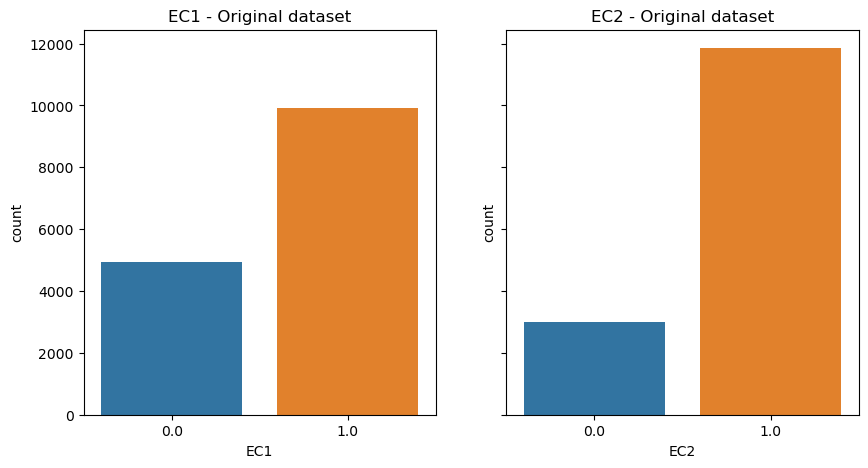

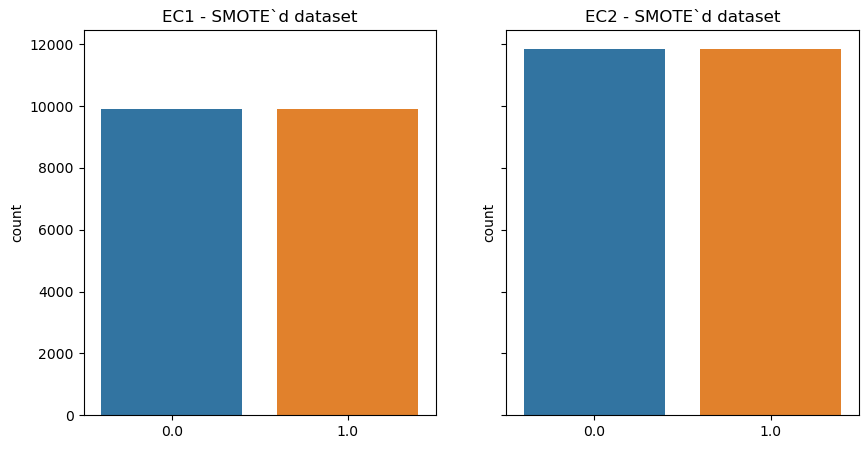

Cases after SMOTE: 19816


In [9]:
# the dataset is unbalanced
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(x="EC1", data=df_train, ax=ax[0])
sns.countplot(x="EC2", data=df_train, ax=ax[1])
ax[0].set_title("EC1 - Original dataset")
ax[1].set_title("EC2 - Original dataset")


X = df_train.drop(["EC1", "EC2"], axis=1).to_numpy()
y_ec1 = df_train["EC1"].to_numpy()
y_ec2 = df_train["EC2"].to_numpy()


print(f"Number of Cases before Oversampling: {len(y_ec1)}")

# we will use SMOTE/ADASYN/RANDOMSAMPLER to oversample the minority class inside the df_train dataframe
# oversample the minority class (uncomment the sampler you want to use)

samplerMod = SMOTE(random_state=42)  # -> synthetic minority oversampling technique
# samplerMod = ADASYN(random_state=42)              # -> adaptive synthetic sampling approach
# samplerMod = RandomOverSampler(random_state=42)   # -> random oversampling


X_ec1, y_ec1 = samplerMod.fit_resample(X, y_ec1)
X_ec2, y_ec2 = samplerMod.fit_resample(X, y_ec2)

# check if dataset is balanced
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(x=y_ec1, ax=ax[0])
sns.countplot(x=y_ec2, ax=ax[1])

# set the title of the plot
ax[0].set_title("EC1 - Oversamplet dataset")
ax[1].set_title("EC2 - Oversamplet dataset")

plt.show()

print(f"Number of Cases after Oversampling: {len(y_ec1)}")

## 2. Min/Max Scaling of the features

In [10]:
# lets use a MinMaxScaler to scale the data

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_ec1)
X_ec1 = scaler.transform(X_ec1)
X_ec2 = scaler.transform(X_ec2)

In [11]:
# set up the toolbox for the gp algorithm on the ec1 target

toolbox_ec1.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox_ec1.register(
    "individual", tools.initIterate, creator.Individual, toolbox_ec1.expr
)
toolbox_ec1.register("population", tools.initRepeat, list, toolbox_ec1.individual)


toolbox_ec1.register("select", tools.selTournament, tournsize=2)
toolbox_ec1.register("mate", gp.cxOnePoint)
toolbox_ec1.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox_ec1.register("mutate", gp.mutUniform, expr=toolbox_ec1.expr_mut, pset=pset)
toolbox_ec1.register("compile", gp.compile, pset=pset)
toolbox_ec1.register("evaluate", evalBinaryClassification, X=X_ec1, y=y_ec1)

# bloat control
toolbox_ec1.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)
toolbox_ec1.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)

# set up the toolbox for the gp algorithm on the ec2 target

toolbox_ec2.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox_ec2.register(
    "individual", tools.initIterate, creator.Individual, toolbox_ec2.expr
)
toolbox_ec2.register("population", tools.initRepeat, list, toolbox_ec2.individual)


toolbox_ec2.register("select", tools.selTournament, tournsize=2)
toolbox_ec2.register("mate", gp.cxOnePoint)
toolbox_ec2.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox_ec2.register("mutate", gp.mutUniform, expr=toolbox_ec2.expr_mut, pset=pset)
toolbox_ec2.register("compile", gp.compile, pset=pset)
toolbox_ec2.register("evaluate", evalBinaryClassification, X=X_ec2, y=y_ec2)

toolbox_ec2.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)
toolbox_ec2.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)

In [12]:
# statistics dictionary
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [13]:
# run the algorithm on the ec1 target

# evolutionary parameters
NGEN_EC1 = 100
POPSIZE_EC1 = 1200
CXPB_EC1 = 0.9
MUTPB_EC1 = 0.1

pop_ec1 = toolbox_ec1.population(n=POPSIZE_EC1)
hof_ec1 = tools.HallOfFame(1)


pop_ec1, log_ec1 = algorithms.eaSimple(
    pop_ec1,
    toolbox_ec1,
    CXPB_EC1,
    MUTPB_EC1,
    NGEN_EC1,
    stats=stats,
    halloffame=hof_ec1,
    verbose=True,
)

# save the winner program as a string in lisp format
try:
    f_ec1_raw = hof_ec1[0]
    print(f_ec1_raw)
except IndexError:
    print("No program found for EC1")
    f_ec1_raw = None

gen	nevals	avg     	std      	min     	max     
0  	1200  	0.486387	0.0822964	0.342563	0.663288
1  	1079  	0.512501	0.0773916	0.343224	0.663288
2  	1088  	0.529651	0.0775431	0.313276	0.659727
3  	1079  	0.540492	0.0770809	0.343224	0.662509
4  	1101  	0.55253 	0.0798883	0.343224	0.661712
5  	1123  	0.555461	0.0840974	0.329724	0.663288
6  	1105  	0.565134	0.082354 	0.323539	0.665472
7  	1104  	0.576434	0.0838024	0.336883	0.663309
8  	1099  	0.588501	0.0798332	0.32542 	0.686612
9  	1107  	0.595191	0.0807252	0.314027	0.676137
10 	1093  	0.606048	0.0756471	0.312011	0.677645
11 	1110  	0.61373 	0.0725453	0.343393	0.677645
12 	1106  	0.616749	0.0729394	0.313968	0.685495
13 	1103  	0.615354	0.0767624	0.313968	0.68289 
14 	1093  	0.616679	0.0758168	0.33383 	0.688753
15 	1096  	0.62227 	0.0725537	0.313968	0.68602 
16 	1110  	0.625914	0.0712869	0.316787	0.695313
17 	1102  	0.627089	0.0730498	0.340568	0.695313
18 	1096  	0.628256	0.0711521	0.314154	0.696717
19 	1069  	0.632226	0.0669014	0.327113	0

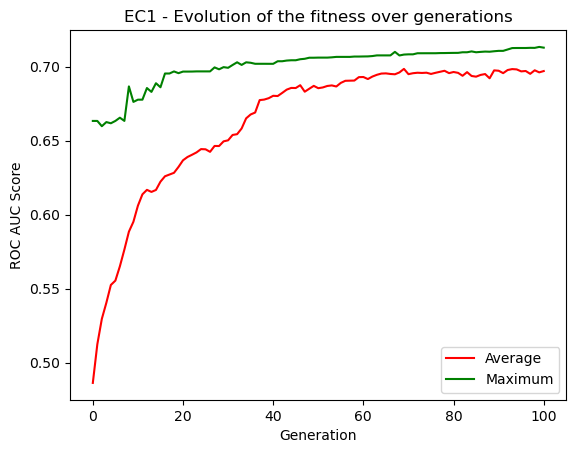

In [14]:
# plot the evolution from the logbook log_ec1
# plot the average, max and std deviation of fitness

try:
    gen_ec1 = log_ec1.select("gen")
    fit_avgs_ec1 = log_ec1.select("avg")
    fit_maxs_ec1 = log_ec1.select("max")

    fig, ax1 = plt.subplots()
    line2 = ax1.plot(gen_ec1, fit_avgs_ec1, "r-", label="Average")
    line3 = ax1.plot(gen_ec1, fit_maxs_ec1, "g-", label="Maximum")

    ax1.set_xlabel("Generation")
    ax1.set_ylabel("ROC AUC Score")

    ax1.set_title("EC1 - Evolution of the fitness over generations")

    ax1.legend()

    plt.show()
except NameError:
    print("No logbook found for EC1")

In [15]:
# run the algorithm on the ec2 target

# evolutionary parameters
NGEN_EC2 = 100
POPSIZE_EC2 = 1200
CXPB_EC2 = 0.9
MUTPB_EC2 = 0.1

pop_ec2 = toolbox_ec2.population(n=POPSIZE_EC2)
hof_ec2 = tools.HallOfFame(1)


pop_ec2, log_ec2 = algorithms.eaSimple(
    pop_ec2,
    toolbox_ec2,
    CXPB_EC2,
    MUTPB_EC2,
    NGEN_EC2,
    stats=stats,
    halloffame=hof_ec2,
    verbose=True,
)

# save the winner program as a "string in lisp format
try:
    f_ec2_raw = hof_ec2[0]
    print(f_ec2_raw)
except IndexError:
    print("No program found for EC2")
    f_ec2_raw = None

gen	nevals	avg     	std     	min    	max     
0  	1200  	0.493373	0.034875	0.36752	0.667668
1  	1099  	0.503952	0.0350979	0.33455	0.667668
2  	1085  	0.50963 	0.0365818	0.373108	0.667668
3  	1106  	0.514936	0.0395594	0.405563	0.669529
4  	1097  	0.51984 	0.0434728	0.352762	0.669271
5  	1095  	0.525505	0.044223 	0.350053	0.669271
6  	1075  	0.532388	0.0463204	0.355511	0.672996
7  	1099  	0.537104	0.0510534	0.355494	0.672091
8  	1080  	0.548179	0.0513994	0.351259	0.670261
9  	1087  	0.555139	0.0542988	0.33639 	0.670377
10 	1087  	0.560183	0.0578419	0.350482	0.670896
11 	1098  	0.561952	0.0631853	0.345174	0.670308
12 	1079  	0.57542 	0.061867 	0.347366	0.671889
13 	1086  	0.578914	0.0656486	0.350457	0.673832
14 	1085  	0.586465	0.0671382	0.334654	0.679672
15 	1077  	0.590451	0.0673598	0.353288	0.680382
16 	1099  	0.598751	0.0675913	0.327745	0.683295
17 	1094  	0.601419	0.0688027	0.344164	0.681783
18 	1102  	0.605191	0.0701994	0.329042	0.683884
19 	1106  	0.609568	0.0698012	0.321759	0.6850

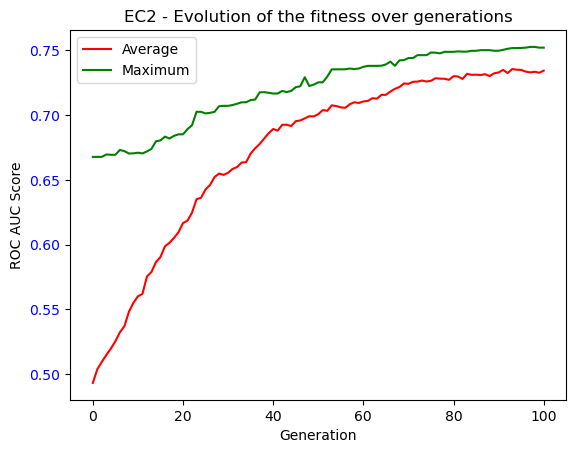

In [16]:
# plot the evolution from the logbook log_ec1
# plot the average, max and std deviation of fitness

try:
    gen_ec2 = log_ec2.select("gen")
    fit_avgs_ec2 = log_ec2.select("avg")
    fit_maxs_ec2 = log_ec2.select("max")

    fig, ax1 = plt.subplots()
    line2 = ax1.plot(gen_ec2, fit_avgs_ec2, "r-", label="Average")
    line3 = ax1.plot(gen_ec2, fit_maxs_ec2, "g-", label="Maximum")

    ax1.set_xlabel("Generation")
    ax1.set_ylabel("ROC AUC Score")

    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax1.set_title("EC2 - Evolution of the fitness over generations")
    ax1.legend()

    plt.show()
except NameError:
    print("No logbook found for EC2")

In [17]:
# predict the labels for the test set

X = df_test.to_numpy()

# if we previously scaled the data, we need to scale the test set in the same way
try:
    # scaler.fit(X)
    X = scaler.transform(X)
except NameError:
    print("No Scaler found")

# ec1
if f_ec1_raw is not None:
    ec1_pred = get_proba(f_ec1_raw, X, pset=pset)

# ec2
if f_ec2_raw is not None:
    ec2_pred = get_proba(f_ec2_raw, X, pset=pset)

# save the predictions in a csv file
try:
    df_result = pd.DataFrame(
        {"id": df_test.index.values, "EC1": ec1_pred, "EC2": ec2_pred}
    )
    df_result.to_csv("results.csv", index=False)

except NameError:
    print("No predictions found")

# EC1 - Hall of Fame

## 1. Basic GP

```{python}
mul(sub(mul(if_lt(neg(add(div(ExactMolWt, Chi2v), sub(tanh(if_lt(div(if_lt(div(HallKierAlpha, fr_COO2), mul(ExactMolWt, neg(FpDensityMorgan1)), NumHeteroatoms, if_lt(div(SlogP_VSA3, BertzCT), sub(ExactMolWt, Chi1), sub(NumHeteroatoms, FpDensityMorgan1), neg(NumHeteroatoms))), BertzCT), sub(ExactMolWt, tanh(mul(BertzCT, cos(neg(HallKierAlpha))))), sub(if_lt(tanh(Kappa3), neg(add(Chi1, if_lt(sub(tanh(NumHeteroatoms), cos(add(NumHeteroatoms, PEOE_VSA8))), EState_VSA1, sub(div(div(ExactMolWt, EState_VSA1), Chi2v), Kappa3), cos(Chi2n)))), MinEStateIndex, ExactMolWt), Chi1n), div(SlogP_VSA3, cos(Chi2v)))), SMR_VSA10))), div(SlogP_VSA3, div(MinEStateIndex, sin(MinEStateIndex))), VSA_EState9, tanh(Kappa3)), MinEStateIndex), if_lt(if_lt(PEOE_VSA14, Chi4n, sin(PEOE_VSA14), Chi1), neg(add(div(div(ExactMolWt, Chi2v), Chi1), sub(Chi4n, mul(if_lt(sin(Chi2n), neg(PEOE_VSA8), HallKierAlpha, PEOE_VSA14), Chi1v)))), cos(EState_VSA1), PEOE_VSA10)), if_lt(div(HallKierAlpha, neg(add(div(FpDensityMorgan1, Chi2v), sub(Chi4n, if_lt(Chi2v, sub(if_lt(tanh(tanh(Kappa3)), add(div(ExactMolWt, Chi2v), if_lt(sub(tanh(SMR_VSA10), sin(EState_VSA2)), sub(if_lt(tanh(Kappa3), Chi3v, Chi1, FpDensityMorgan1), EState_VSA1), Chi2v, cos(Chi2n))), Chi1, ExactMolWt), mul(BertzCT, MinEStateIndex)), sub(Chi1, Kappa3), mul(if_lt(HallKierAlpha, VSA_EState9, Chi2n, EState_VSA1), neg(FpDensityMorgan1))))))), mul(mul(mul(HallKierAlpha, fr_COO2), neg(PEOE_VSA14)), neg(FpDensityMorgan1)), NumHeteroatoms, if_lt(div(SlogP_VSA3, BertzCT), sub(ExactMolWt, Chi1), if_lt(div(HallKierAlpha, neg(add(div(FpDensityMorgan1, neg(add(div(ExactMolWt, Chi2v), sub(tanh(if_lt(sin(MinEStateIndex), sub(Chi2v, div(SlogP_VSA3, BertzCT)), sub(ExactMolWt, Chi1n), div(mul(BertzCT, MinEStateIndex), sub(NumHeteroatoms, div(Chi1v, MinEStateIndex))))), SMR_VSA10)))), sub(Chi4n, if_lt(Chi2v, sub(if_lt(tanh(Kappa3), add(div(ExactMolWt, Chi2v), if_lt(sub(tanh(SMR_VSA10), sin(EState_VSA2)), tanh(SlogP_VSA3), Chi2v, cos(Chi2n))), Chi1, ExactMolWt), EState_VSA1), sub(Chi1, Kappa3), mul(if_lt(HallKierAlpha, VSA_EState9, Chi2n, EState_VSA1), neg(FpDensityMorgan1))))))), mul(ExactMolWt, neg(FpDensityMorgan1)), NumHeteroatoms, if_lt(div(SlogP_VSA3, BertzCT), sub(add(div(ExactMolWt, Chi2v), sub(tanh(if_lt(div(if_lt(div(HallKierAlpha, EState_VSA1), mul(NumHeteroatoms, neg(FpDensityMorgan1)), NumHeteroatoms, Chi4n), BertzCT), sub(Chi2v, tanh(mul(BertzCT, cos(neg(HallKierAlpha))))), sub(ExactMolWt, Kappa3), div(SlogP_VSA3, cos(FpDensityMorgan3)))), SMR_VSA10)), Chi1), sub(NumHeteroatoms, FpDensityMorgan1), SMR_VSA10)), SMR_VSA10)))
```

*ROC_AUC_SCORE=0.68849*

## 2. High Popsize (=1200) and number of Generations (=100)


```{python}
if_lt(if_lt(NumHeteroatoms, if_lt(sub(if_lt(cos(neg(SMR_VSA10)), if_lt(-1, FpDensityMorgan2, sub(PEOE_VSA6, PEOE_VSA6), VSA_EState9), mul(NumHeteroatoms, if_lt(cos(MaxAbsEStateIndex), if_lt(mul(sub(PEOE_VSA8, PEOE_VSA6), HallKierAlpha), add(FpDensityMorgan1, if_lt(Chi3v, sub(if_lt(FpDensityMorgan1, sub(PEOE_VSA6, if_lt(sub(tanh(1), tanh(Chi4n)), sub(MaxAbsEStateIndex, sub(MaxAbsEStateIndex, HallKierAlpha)), HallKierAlpha, PEOE_VSA7)), Chi4n, EState_VSA1), neg(Chi4n)), NumHeteroatoms, Chi4n)), sub(NumHeteroatoms, tanh(add(NumHeteroatoms, NumHeteroatoms))), PEOE_VSA6), NumHeteroatoms, Chi4n)), NumHeteroatoms), HallKierAlpha), sub(PEOE_VSA6, PEOE_VSA6), EState_VSA1, 0), tanh(MaxAbsEStateIndex), Chi2v), MaxAbsEStateIndex, neg(sub(NumHeteroatoms, MinEStateIndex)), if_lt(if_lt(PEOE_VSA14, sub(tanh(neg(if_lt(cos(MaxAbsEStateIndex), sub(if_lt(FpDensityMorgan1, cos(sub(FpDensityMorgan1, div(if_lt(MinEStateIndex, Kappa3, cos(Chi4n), FpDensityMorgan1), sin(HeavyAtomMolWt)))), Chi4n, EState_VSA1), sub(EState_VSA1, sub(MaxAbsEStateIndex, HallKierAlpha))), NumHeteroatoms, sub(NumHeteroatoms, MinEStateIndex)))), PEOE_VSA6), tanh(VSA_EState9), sub(sub(if_lt(cos(neg(SMR_VSA10)), sin(if_lt(VSA_EState9, sub(MaxAbsEStateIndex, sub(MaxAbsEStateIndex, HallKierAlpha)), cos(neg(SMR_VSA10)), Chi3v)), mul(NumHeteroatoms, if_lt(cos(MaxAbsEStateIndex), if_lt(VSA_EState9, add(FpDensityMorgan1, Chi2v), sub(NumHeteroatoms, tanh(add(mul(EState_VSA1, neg(cos(mul(mul(EState_VSA1, PEOE_VSA7), NumHeteroatoms)))), NumHeteroatoms))), PEOE_VSA6), NumHeteroatoms, Chi4n)), PEOE_VSA14), cos(Chi4n)), cos(Chi2v))), SMR_VSA10, MinEStateIndex, neg(MaxAbsEStateIndex)))
```



*ROC_AUC_SCORE=0.690712*

## 3. High Popsize (=1200) and number of Generations (=100) with Smote and MinMax-Scaler

```{python}
mul(sub(sub(sub(SMR_VSA10, mul(fr_COO, mul(SlogP_VSA3, sub(div(tanh(VSA_EState9), tanh(mul(mul(PEOE_VSA7, mul(fr_COO, PEOE_VSA10)), sub(div(FpDensityMorgan2, SlogP_VSA3), neg(sub(SMR_VSA10, mul(fr_COO, fr_COO2))))))), neg(neg(NumHeteroatoms)))))), mul(fr_COO, sub(SMR_VSA10, mul(fr_COO, fr_COO2)))), sub(mul(if_lt(mul(if_lt(tanh(NumHeteroatoms), add(PEOE_VSA7, sin(FpDensityMorgan1)), neg(mul(fr_COO2, mul(PEOE_VSA14, if_lt(neg(add(Chi1, NumHeteroatoms)), fr_COO2, -1, PEOE_VSA10)))), SlogP_VSA3), mul(if_lt(cos(fr_COO), add(PEOE_VSA7, sin(add(div(if_lt(PEOE_VSA14, FpDensityMorgan3, cos(SlogP_VSA3), VSA_EState9), sub(PEOE_VSA10, sub(div(sub(PEOE_VSA10, sub(EState_VSA1, PEOE_VSA14)), cos(Chi1)), PEOE_VSA14))), sin(add(div(EState_VSA2, if_lt(neg(MaxAbsEStateIndex), NumHeteroatoms, HeavyAtomMolWt, VSA_EState9)), add(PEOE_VSA14, NumHeteroatoms)))))), mul(add(neg(PEOE_VSA14), EState_VSA1), PEOE_VSA6), SlogP_VSA3), mul(if_lt(cos(sin(MinEStateIndex)), SlogP_VSA3, div(PEOE_VSA6, sin(neg(Kappa3))), sin(neg(mul(NumHeteroatoms, tanh(EState_VSA1))))), NumHeteroatoms))), EState_VSA1, add(neg(PEOE_VSA14), EState_VSA1), FpDensityMorgan3), sub(sub(SMR_VSA10, FpDensityMorgan2), MinEStateIndex)), -1)), NumHeteroatoms)
```

*ROC_AUC_SCORE=0.712769*



# EC2 - Hall of Fame

## Basic GP
```{python}
sin(div(div(if_lt(EState_VSA1, mul(VSA_EState9, div(SMR_VSA10, if_lt(fr_COO, VSA_EState9, fr_COO, fr_COO))), sub(NumHeteroatoms, VSA_EState9), sin(tanh(EState_VSA1))), if_lt(fr_COO, add(mul(add(tanh(sin(HallKierAlpha)), fr_COO), fr_COO), sub(mul(VSA_EState9, div(mul(MinEStateIndex, tanh(Chi1v)), div(sin(if_lt(MinEStateIndex, SMR_VSA10, SlogP_VSA3, fr_COO)), Chi1v))), fr_COO)), fr_COO, add(tanh(PEOE_VSA6), PEOE_VSA6))), if_lt(if_lt(cos(div(add(add(EState_VSA1, mul(if_lt(Chi2v, Chi4n, MaxAbsEStateIndex, SMR_VSA5), fr_COO)), sub(div(if_lt(tanh(PEOE_VSA10), sin(if_lt(MinEStateIndex, FpDensityMorgan3, SlogP_VSA3, fr_COO)), sin(HallKierAlpha), sin(tanh(MinEStateIndex))), Chi1v), sub(div(SMR_VSA10, SMR_VSA10), SMR_VSA5))), if_lt(cos(mul(SMR_VSA10, fr_COO)), add(tanh(FpDensityMorgan2), sub(EState_VSA1, PEOE_VSA14)), fr_COO, fr_COO))), add(MinEStateIndex, sub(div(SMR_VSA10, tanh(add(EState_VSA1, mul(SMR_VSA10, fr_COO)))), PEOE_VSA6)), cos(div(add(PEOE_VSA6, if_lt(div(mul(div(mul(mul(tanh(VSA_EState9), sub(-1, Chi2v)), tanh(MinEStateIndex)), neg(FpDensityMorgan2)), PEOE_VSA6), SMR_VSA10), sin(Chi3v), sin(PEOE_VSA7), tanh(Chi4n))), if_lt(div(mul(tanh(PEOE_VSA6), div(sin(if_lt(MinEStateIndex, FpDensityMorgan3, SlogP_VSA3, fr_COO)), fr_COO)), mul(FpDensityMorgan3, fr_COO)), add(tanh(SMR_VSA10), if_lt(if_lt(PEOE_VSA10, HallKierAlpha, SMR_VSA5, fr_COO), add(fr_COO, fr_COO), mul(VSA_EState9, mul(tanh(mul(fr_COO, div(cos(SMR_VSA10), fr_COO))), MinEStateIndex)), fr_COO)), fr_COO, sin(SMR_VSA10)))), VSA_EState9), neg(FpDensityMorgan2), fr_COO, VSA_EState9)))
```

*ROC_AUC_SCORE=0.578397*

## ## 2. High Popsize (=1200) and number of Generations (=100)


```{python}
sub(sin(if_lt(add(fr_COO2, Chi3v), FpDensityMorgan1, cos(if_lt(add(if_lt(add(mul(sin(PEOE_VSA8), FpDensityMorgan1), Chi1n), tanh(div(FpDensityMorgan2, div(sin(sin(Kappa3)), cos(EState_VSA1)))), PEOE_VSA6, if_lt(fr_COO2, fr_COO2, FpDensityMorgan3, if_lt(PEOE_VSA10, Chi2n, fr_COO, Chi1n))), Chi1n), tanh(div(FpDensityMorgan2, div(mul(cos(Chi3v), if_lt(PEOE_VSA7, mul(PEOE_VSA10, FpDensityMorgan2), FpDensityMorgan1, if_lt(fr_COO2, tanh(neg(fr_COO)), mul(HeavyAtomMolWt, mul(EState_VSA1, add(fr_COO2, Chi1n))), add(tanh(NumHeteroatoms), if_lt(if_lt(fr_COO2, VSA_EState9, FpDensityMorgan1, if_lt(1, Kappa3, Chi3v, Chi2v)), MaxAbsEStateIndex, fr_COO, NumHeteroatoms))))), cos(EState_VSA1)))), PEOE_VSA6, if_lt(fr_COO2, fr_COO, FpDensityMorgan3, if_lt(PEOE_VSA10, Chi1n, PEOE_VSA14, Chi1n)))), sin(if_lt(add(PEOE_VSA6, add(tanh(div(Chi1n, sin(Chi3v))), fr_COO2)), FpDensityMorgan1, cos(if_lt(tanh(MaxAbsEStateIndex), sub(PEOE_VSA8, mul(neg(mul(add(Chi3v, fr_COO), neg(sin(PEOE_VSA8)))), cos(fr_COO2))), tanh(PEOE_VSA14), fr_COO2)), PEOE_VSA14)))), if_lt(sin(fr_COO), if_lt(div(PEOE_VSA8, cos(PEOE_VSA14)), -1, tanh(add(if_lt(mul(if_lt(NumHeteroatoms, MinEStateIndex, add(if_lt(PEOE_VSA14, cos(EState_VSA1), NumHeteroatoms, MinEStateIndex), Chi3v), fr_COO), fr_COO), sin(fr_COO2), Chi1v, PEOE_VSA14), mul(Kappa3, Chi2n))), fr_COO), if_lt(div(PEOE_VSA7, cos(PEOE_VSA14)), fr_COO2, tanh(ExactMolWt), fr_COO), if_lt(sin(sin(fr_COO)), HallKierAlpha, sin(sin(fr_COO)), fr_COO)))
```

*ROC_AUC_SCORE=0.58231*

## 3. High Popsize (=1200) and number of Generations (=100) with Smote and MinMax-Scaler

```{python}
sub(sub(mul(MinEStateIndex, cos(fr_COO)), div(div(if_lt(EState_VSA2, mul(neg(EState_VSA2), SlogP_VSA3), add(if_lt(FpDensityMorgan2, MaxAbsEStateIndex, fr_COO, div(-1, div(Kappa3, MaxAbsEStateIndex))), tanh(PEOE_VSA14)), VSA_EState9), tanh(cos(mul(neg(neg(add(neg(fr_COO2), neg(if_lt(EState_VSA2, neg(mul(if_lt(PEOE_VSA7, VSA_EState9, HeavyAtomMolWt, cos(PEOE_VSA6)), fr_COO)), Kappa3, cos(add(PEOE_VSA8, fr_COO))))))), Chi1n)))), EState_VSA2)), sub(add(div(cos(add(if_lt(tanh(SMR_VSA5), EState_VSA1, fr_COO, fr_COO2), VSA_EState9)), fr_COO), add(sub(add(div(cos(PEOE_VSA10), cos(PEOE_VSA6)), add(add(neg(mul(add(div(-1, div(div(PEOE_VSA7, MaxAbsEStateIndex), MaxAbsEStateIndex)), Chi2v), div(add(BertzCT, SlogP_VSA3), add(fr_COO, cos(fr_COO))))), if_lt(neg(fr_COO2), if_lt(mul(add(fr_COO2, PEOE_VSA7), sin(mul(Chi2v, Chi1))), VSA_EState9, FpDensityMorgan2, cos(PEOE_VSA6)), PEOE_VSA10, PEOE_VSA14)), neg(mul(div(div(Kappa3, PEOE_VSA7), if_lt(sin(mul(add(-1, MinEStateIndex), PEOE_VSA7)), if_lt(PEOE_VSA7, VSA_EState9, HeavyAtomMolWt, if_lt(PEOE_VSA7, VSA_EState9, HeavyAtomMolWt, sub(tanh(add(neg(fr_COO), neg(Chi4n))), fr_COO))), PEOE_VSA10, PEOE_VSA14)), neg(Kappa3))))), mul(div(div(add(tanh(PEOE_VSA14), sin(MaxAbsEStateIndex)), PEOE_VSA8), if_lt(sin(mul(add(-1, if_lt(div(div(VSA_EState9, PEOE_VSA8), if_lt(Chi1, if_lt(EState_VSA2, VSA_EState9, HeavyAtomMolWt, cos(PEOE_VSA6)), PEOE_VSA10, PEOE_VSA14)), VSA_EState9, HeavyAtomMolWt, cos(PEOE_VSA6))), PEOE_VSA7)), if_lt(PEOE_VSA7, sub(0, 0), HeavyAtomMolWt, cos(PEOE_VSA6)), PEOE_VSA10, PEOE_VSA14)), neg(Kappa3))), sub(sub(add(add(div(div(if_lt(EState_VSA2, add(neg(mul(add(div(-1, div(PEOE_VSA7, MaxAbsEStateIndex)), Chi2v), div(add(BertzCT, SlogP_VSA3), add(fr_COO, cos(fr_COO))))), if_lt(sin(mul(sin(fr_COO2), PEOE_VSA7)), if_lt(PEOE_VSA7, VSA_EState9, FpDensityMorgan2, Chi1), PEOE_VSA10, PEOE_VSA14)), HeavyAtomMolWt, VSA_EState9), tanh(cos(add(mul(fr_COO, Chi1), cos(FpDensityMorgan3))))), PEOE_VSA8), if_lt(sin(mul(sin(fr_COO2), PEOE_VSA7)), if_lt(PEOE_VSA10, VSA_EState9, FpDensityMorgan2, cos(PEOE_VSA6)), PEOE_VSA10, PEOE_VSA14)), tanh(PEOE_VSA8)), mul(ExactMolWt, VSA_EState9)), mul(PEOE_VSA14, neg(Chi1))))), mul(neg(EState_VSA2), SlogP_VSA3)))
```

*ROC_AUC_SCORE=0.751886*